In [7]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from tqdm import tqdm
import featuretools as ft
import warnings 
warnings.filterwarnings('ignore')
import time

# Check datasets

## Read dataset

In [8]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [10]:
print(df_train.shape, df_test.shape)

# train, test set의 행, 열 count

(9557, 143) (23856, 142)


In [11]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [12]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


## Make description df

In [14]:
# 생략

## Check null data

In [16]:
# null count
total = df_train.isnull().sum().sort_values(ascending=False)
# null percentage
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_df.head(20)

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
SQBmeaned,5,0.052318
meaneduc,5,0.052318
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [17]:
df_train[['edjefa','edjefe']]

,edjefa,edjefe
0,no,10
1,no,12
2,11,no
3,no,11
4,no,11
...,...,...
9552,no,9
9553,no,9
9554,no,9
9555,no,9


## Fill missing values

In [18]:
# eduction = yes & person = head of household 이면 escolari로 채움

df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# edjefa = yes, edjefe = yes이면 4로 치환
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

# 'edjef' 피처 생성: edjefa, edjefe 중 max 값 (?)
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

#
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

**rez_esz, SQBmeaned**
* rez_esc : 교육기간 -> 0으로 채움
* SQBmeaned : 성인의 교육기간 평균의 제곱 -> 0으로 채움

In [19]:
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

In [20]:
df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

**meaneduc**
* meaneduc : 성인의 평균 교육기간 -> 0으로 채움

In [21]:
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

**v18q1**
* v18q1 : 가정이 소유한 태블릿 수 

    v18q = 1 이면 v18q1은 1~6의 정수값을 갖고

    v18q = 0 이면 v18q1 = NaN

In [22]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [23]:
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [24]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

In [25]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

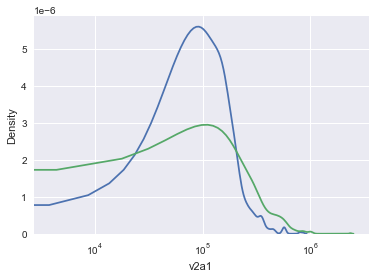

In [26]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'], label='Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'], label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.show()

In [27]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [28]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
v2a1,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_mayor,0,0.0
hogar_total,0,0.0


결측값 모두 채움!

# Feature engineering

## Object features

속성이 object인 피처들을 살펴보자

In [29]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [30]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

**dependency**

In [32]:
# Na로 되어있는 값들은 제곱값의 제곱근으로 채우자
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])